# What are we embedding?

In [12]:

from utilities import capture_full, embed, build_session
from PIL import Image
import io
import numpy as np

In [13]:
click_x = 645
click_y = 818

full_img   = capture_full()
full_img.show()

In [14]:
resized = full_img.resize((512, 512), Image.Resampling.BICUBIC)
resized.show()

In [15]:

import onnxruntime as ort              # ONNX Runtime

session = ort.InferenceSession("tiny_clip/model.onnx")

for i, out in enumerate(session.get_outputs()):
    print(f"[Output {i}] name={out.name} shape={out.shape} type={out.type}")


[Output 0] name=logits_per_image shape=['image_batch_size', 'text_batch_size'] type=tensor(float)
[Output 1] name=logits_per_text shape=['text_batch_size', 'image_batch_size'] type=tensor(float)
[Output 2] name=text_embeds shape=['text_batch_size', 512] type=tensor(float)
[Output 3] name=image_embeds shape=['image_batch_size', 512] type=tensor(float)


In [16]:
def compress_image(img, quality=85):
    import io
    buf = io.BytesIO()
    img.save(buf, format="JPEG", quality=quality)
    return buf.getvalue()

def get_clip_embedding_from_blob(blob: bytes, session) -> np.ndarray:
    """Takes a full screen image blob (JPEG or raw RGB), returns CLIP vector."""
    img = Image.open(io.BytesIO(blob)).convert("RGB")  # load from blob
    resized = img.resize((224, 224), Image.Resampling.BICUBIC)
    
    buf = io.BytesIO()
    resized.save(buf, format="JPEG", quality=85)  # or keep as raw RGB
    jpeg_bytes = buf.getvalue()

    return embed(session, jpeg_bytes)


import onnxruntime as ort              # ONNX Runtime

session = ort.InferenceSession("tiny_clip/model.onnx")

for i, out in enumerate(session.get_outputs()):
    print(f"[Output {i}] name={out.name} shape={out.shape} type={out.type}")

session  = build_session()

click_x = 645
click_y = 818

full_img   = capture_full()

screen_blob = compress_image(full_img)
# turn the same image into JPEG for CLIP

vec = get_clip_embedding_from_blob(screen_blob, session)
print(f"[embed] vector shape: {vec.shape}, dtype: {vec.dtype}")

[Output 0] name=logits_per_image shape=['image_batch_size', 'text_batch_size'] type=tensor(float)
[Output 1] name=logits_per_text shape=['text_batch_size', 'image_batch_size'] type=tensor(float)
[Output 2] name=text_embeds shape=['text_batch_size', 512] type=tensor(float)
[Output 3] name=image_embeds shape=['image_batch_size', 512] type=tensor(float)
[embed] vector shape: (512,), dtype: float32


In [17]:
print(bytes(vec))

b']\xb2\xcb\xbb0\xce\\\xb9)\x17d<\xe0\x92V\xbc\xee/.<i\xbbj\xbc\\-\xa2<\xb9\x82\xef:\x96em=`7\xf6;-\xaa1=\xe1\x0b\xca\xbc#\xe8\x0b\xbd\n\xbf\xea\xbcf.r\xbc\xe2\xf2\x05\xbd\x1a\x0f\x0b\xbd\x8f@\x80:\xdd\xb5S;\x18\xfbv\xbdTY\x0b>q\x0c\xdd<&R\xf6;\x90H\xd7\xbb\x14"\x9b\xbd\\aO<X\xae\xe7\xbc\x92Z\xf0<\x13X\x04\xbd>M\xf1<\xa3"M<\x02\x98\x88<\xc0\n\xc7:Pm\x08=\xc7p)=c\xb7\xbd;e\'\x02\xbd\x9aB\xc0<\x92\xa0\xa0;\x14\x8d\x16\xbeJ\xac\xf4\xbc5H\x7f\xbc\x14 \xd3\xbb\x01;?\xbd}6\x86\xbc\xe8\xcf\x07\xbd\x9b\x16\x8b\xba\x14S\xce<\xd8E\x97<\xab\x91\x00<\xd5MS<\xc4\x19\x14\xbc*\x06\xbb;:\xcb\xfd;\xa2k\x0f=\xa8<L\xbc\x10\xdf\xbf\xbc\x1d0*\xbb\xfeK^<>R\x91<F0\x0c\xbe\xdeB1<OM\x17=L\xf3\x02\xbdj\xe9\xa5\xbb\xc0\xacs\xbc" \xb1\xbc\xcd\xe7\xd8\xbc^\xca\xd8<\xb9l\xad\xbc\xc3.\xba\xbb\x95\xe0{\xbc\xf5\xaf\xff<;-\x07\xbcv@\x00\xbda\xd7\x83\xbcM(\x81\xbcf\xfa\xc4\xbcfs\x01\xbd\xeb#\xbb\xbc\x9eT\xd1\xbc\xc2 \x00=_\xd0-=\x01T\x1c\xbb\'\xa4\x06<\xb0B\xbe;\xab\xf0\xe8=\xd3\x01\x11\xbc\x0e\xad.<\x80\'a\xbagU(<\xcf\

# Mapping the vector space

✅ Loaded 115 valid vectors
✅ Loaded 115 vectors


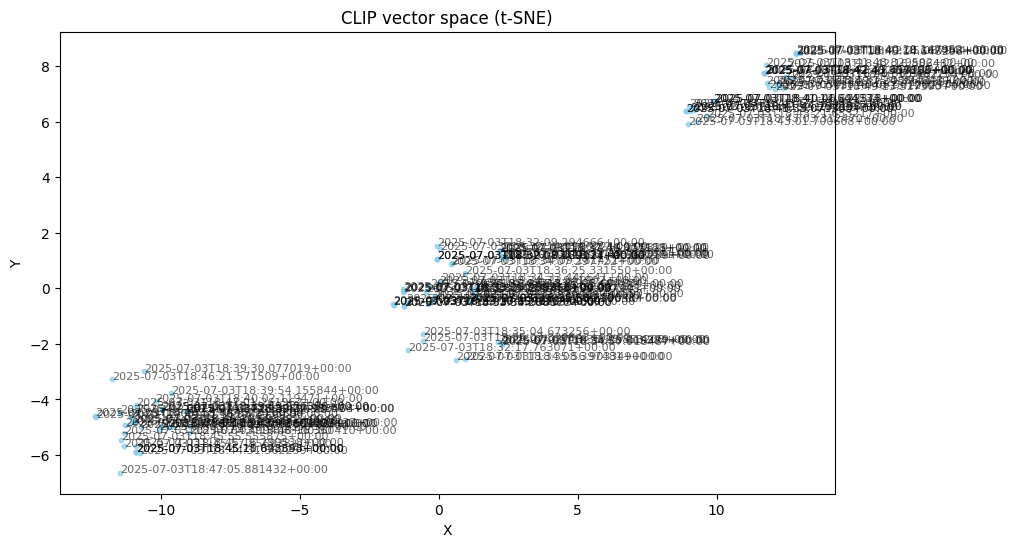

In [18]:
import sqlite3, numpy as np

def load_vectors(db_path="screen_log.db") -> tuple[list[str], np.ndarray]:
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.execute("SELECT ts, vec FROM mouse_clicks ORDER BY ts")
    rows = cur.fetchall()
    
    timestamps = []
    vectors = []
    for ts, blob in rows:
        vec = np.frombuffer(blob, dtype=np.float32)
        if vec.shape != (512,):  # or whatever your CLIP vector size is
            print(f"⚠️ Skipping malformed vec at {ts}: shape {vec.shape}")
            continue
        timestamps.append(ts)
        vectors.append(vec)
    
    print(f"✅ Loaded {len(vectors)} valid vectors")
    return timestamps, np.stack(vectors)


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_vectors_2d(vectors, labels=None):
    if len(vectors) < 2:
        print(f"⚠️ Not enough vectors to plot: got {len(vectors)} (need at least 2)")
        return

    tsne = TSNE(n_components=2, perplexity=min(30, max(5, len(vectors) // 2)), random_state=42)
    proj = tsne.fit_transform(vectors)

    plt.figure(figsize=(10, 6))
    plt.scatter(proj[:, 0], proj[:, 1], c='skyblue', s=10, alpha=0.7)

    if labels:
        for (x, y), label in zip(proj, labels):
            plt.text(x, y, label, fontsize=8, alpha=0.6)

    plt.title("CLIP vector space (t-SNE)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()



timestamps, vecs = load_vectors("screen_log.db")
print(f"✅ Loaded {len(vecs)} vectors")
plot_vectors_2d(vecs, labels=timestamps)


✅ Loaded 115 valid vectors


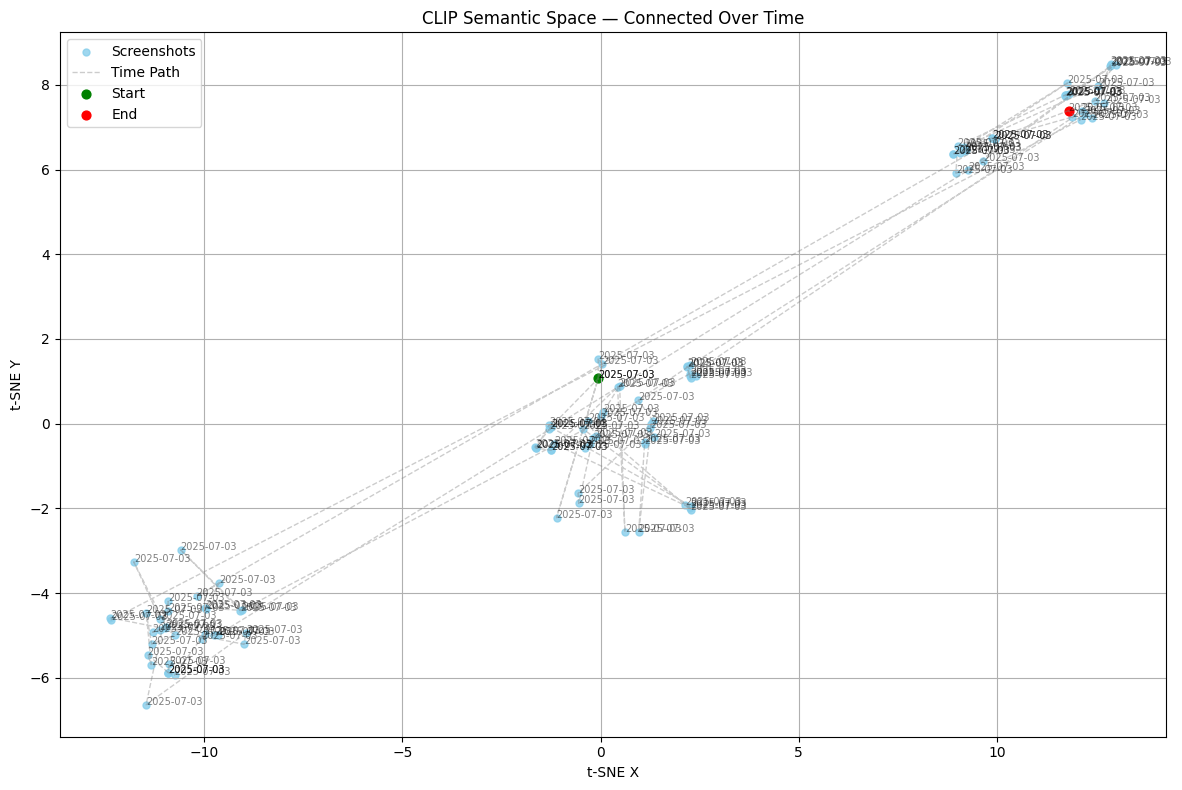

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_vectors_2d(vectors, labels=None, connect_by_time=True):
    if len(vectors) < 2:
        print(f"⚠️ Not enough vectors to plot: got {len(vectors)} (need at least 2)")
        return

    tsne = TSNE(n_components=2, perplexity=min(30, max(5, len(vectors) // 2)), random_state=42)
    proj = tsne.fit_transform(vectors)

    plt.figure(figsize=(12, 8))
    
    # Draw scatter points
    plt.scatter(proj[:, 0], proj[:, 1], c='skyblue', s=25, alpha=0.8, label='Screenshots')

    # Optionally connect the dots in temporal order
    if connect_by_time:
        plt.plot(proj[:, 0], proj[:, 1], color='gray', alpha=0.4, linewidth=1, linestyle='--', label='Time Path')

    # Optional: label first and last point
    plt.scatter(proj[0, 0], proj[0, 1], c='green', label='Start', s=40)
    plt.scatter(proj[-1, 0], proj[-1, 1], c='red', label='End', s=40)

    # Optional labels
    if labels:
        for (x, y), label in zip(proj, labels):
            plt.text(x, y, label[:10], fontsize=7, alpha=0.5)

    plt.title("CLIP Semantic Space — Connected Over Time")
    plt.xlabel("t-SNE X")
    plt.ylabel("t-SNE Y")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
timestamps, vecs = load_vectors("screen_log.db")
plot_vectors_2d(vecs, labels=timestamps)


/Users/campbellharris/Desktop/trojan/trojan/python/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/campbellharris/Desktop/trojan/trojan/python/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


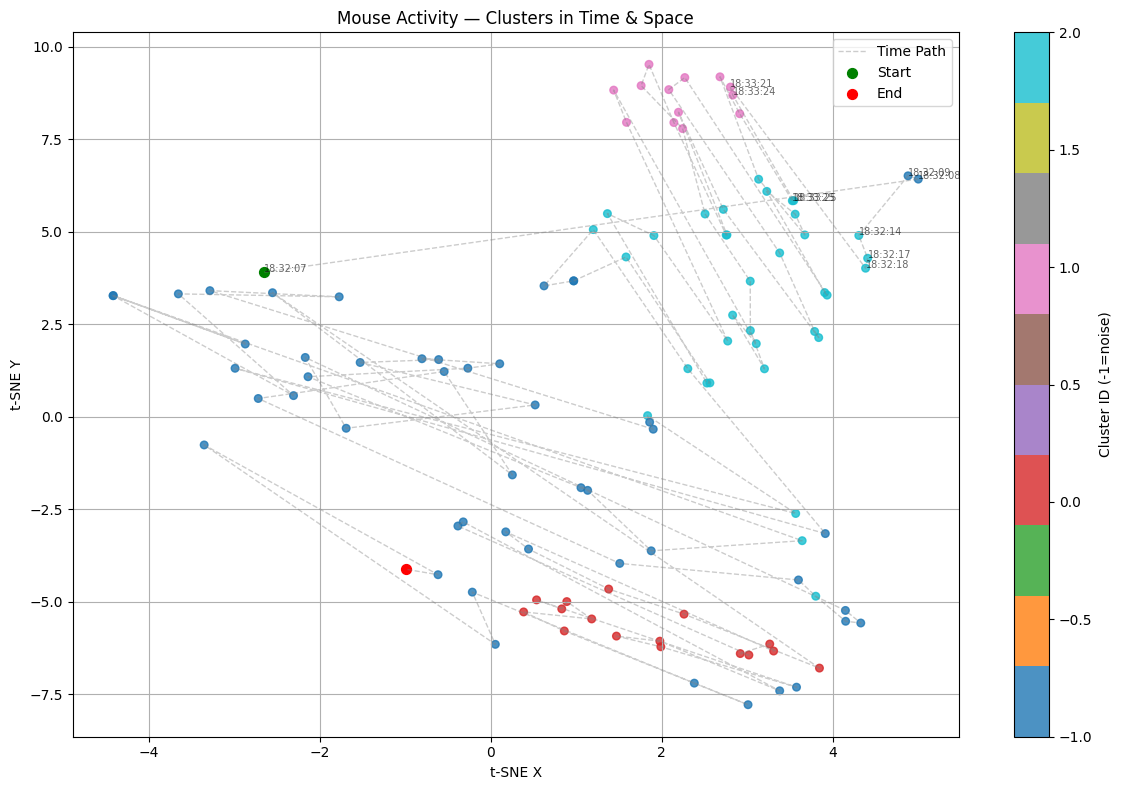

In [20]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import hdbscan  # pip install hdbscan

def load_mouse_click_features(db_path="screen_log.db"):
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.execute("SELECT ts, x_perc, y_perc FROM mouse_clicks ORDER BY ts")
    
    timestamps = []
    features = []
    for ts, x, y in cur.fetchall():
        try:
            unix_time = datetime.fromisoformat(ts.replace("Z", "")).timestamp()
            timestamps.append(ts)
            features.append([unix_time, x, y])
        except:
            continue
    return timestamps, np.array(features)

def cluster_and_plot_temporal_spatial(timestamps, features):
    # Normalize features (time + screen % coords)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(features)

    # HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
    labels = clusterer.fit_predict(scaled)

    # t-SNE projection
    proj = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(scaled)

    # Plotting
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='tab10', s=30, alpha=0.8)

    # Optional: draw temporal path
    plt.plot(proj[:, 0], proj[:, 1], color='gray', alpha=0.4, linewidth=1, linestyle='--', label='Time Path')

    # Mark start and end
    plt.scatter(proj[0, 0], proj[0, 1], c='green', label='Start', s=50)
    plt.scatter(proj[-1, 0], proj[-1, 1], c='red', label='End', s=50)

    # Optional: label first N points
    for (x, y), label in zip(proj[:10], timestamps[:10]):
        plt.text(x, y, label[11:19], fontsize=7, alpha=0.6)

    plt.title("Mouse Activity — Clusters in Time & Space")
    plt.xlabel("t-SNE X")
    plt.ylabel("t-SNE Y")
    plt.colorbar(scatter, label='Cluster ID (-1=noise)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Run it ---
timestamps, features = load_mouse_click_features()
cluster_and_plot_temporal_spatial(timestamps, features)


the pages on loading from the mouse_clicks is what we save. These pages are very consistent and are good for our clustering algorithm.

I tried to add mouse click locations and titles but that did not separate the activities enough.

✅ Loaded 115 valid vectors

📊 Cluster frequencies:
  Cluster #3: 35 vectors
  Cluster #1: 34 vectors
  Cluster #0: 12 vectors
  Cluster #9: 7 vectors
  Cluster #8: 7 vectors
  Cluster #6: 6 vectors
  Cluster #5: 4 vectors
  Cluster #4: 4 vectors
  Cluster #7: 3 vectors
  Cluster #2: 3 vectors

🔍 Top 3 cluster details:

🧠 Cluster #3 — 35 entries:
    2025-07-03T18:32:07.281124+00:00 — 2025-07-03T18:32:07.281124+00:00
    2025-07-03T18:32:08.429024+00:00 — 2025-07-03T18:32:08.429024+00:00
    2025-07-03T18:32:09.294666+00:00 — 2025-07-03T18:32:09.294666+00:00
    2025-07-03T18:32:14.090622+00:00 — 2025-07-03T18:32:14.090622+00:00
    2025-07-03T18:32:17.763071+00:00 — 2025-07-03T18:32:17.763071+00:00
    2025-07-03T18:32:18.669211+00:00 — 2025-07-03T18:32:18.669211+00:00
    2025-07-03T18:33:21.888778+00:00 — 2025-07-03T18:33:21.888778+00:00
    2025-07-03T18:33:24.239865+00:00 — 2025-07-03T18:33:24.239865+00:00
    2025-07-03T18:33:26.639056+00:00 — 2025-07-03T18:33:26.639056+00:00
    

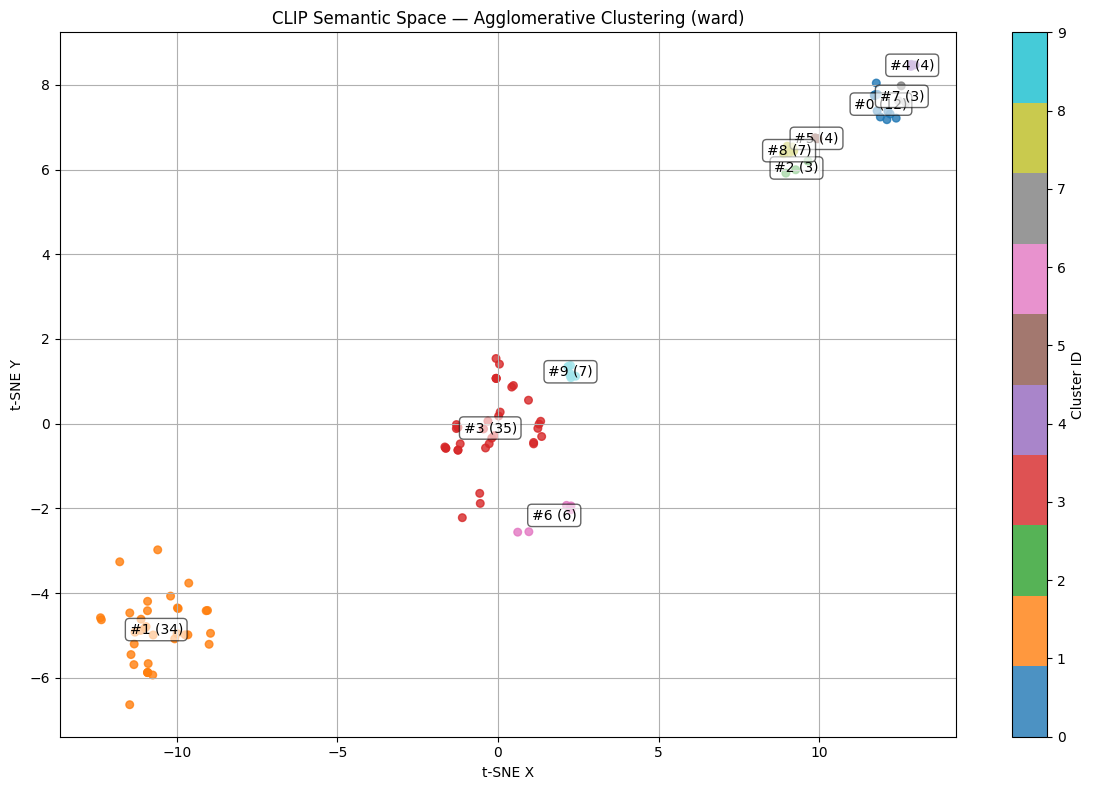

In [21]:
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np

def analyze_agglomerative_clusters(vectors, labels, timestamps, n_clusters=10, linkage='ward', top_n=3):
    # Clustering
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    cluster_labels = model.fit_predict(vectors)

    # Count frequency
    counts = Counter(cluster_labels)
    print(f"\n📊 Cluster frequencies:")
    for cid, freq in counts.most_common():
        print(f"  Cluster #{cid}: {freq} vectors")

    # Organize metadata
    cluster_meta = defaultdict(list)
    for i, cid in enumerate(cluster_labels):
        cluster_meta[cid].append((timestamps[i], labels[i] if labels else ''))

    print(f"\n🔍 Top {top_n} cluster details:")
    for cid, _ in counts.most_common(top_n):
        print(f"\n🧠 Cluster #{cid} — {len(cluster_meta[cid])} entries:")
        for ts, label in cluster_meta[cid][:10]:  # Print top 10 only
            print(f"    {ts} — {label}")

    return cluster_labels


def plot_vectors_with_agglomerative(vectors, labels=None, timestamps=None, n_clusters=10, linkage='ward'):
    if len(vectors) < 2:
        print(f"⚠️ Not enough vectors to plot: got {len(vectors)} (need at least 2)")
        return

    # t-SNE projection
    tsne = TSNE(n_components=2, perplexity=min(30, max(5, len(vectors)//2)), random_state=42)
    proj = tsne.fit_transform(vectors)

    # Cluster & analyze
    cluster_labels = analyze_agglomerative_clusters(vectors, labels, timestamps, n_clusters=n_clusters, linkage=linkage)

    # Plotting
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(proj[:, 0], proj[:, 1], c=cluster_labels, cmap='tab10', s=30, alpha=0.8)

    # Annotate clusters
    counts = Counter(cluster_labels)
    for cluster_id in sorted(counts.keys()):
        idx = np.where(cluster_labels == cluster_id)[0]
        center_x = np.mean(proj[idx, 0])
        center_y = np.mean(proj[idx, 1])
        freq = counts[cluster_id]
        plt.text(center_x, center_y, f'#{cluster_id} ({freq})', fontsize=10,
                 ha='center', va='center',
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', alpha=0.6))

    plt.title(f"CLIP Semantic Space — Agglomerative Clustering ({linkage})")
    plt.xlabel("t-SNE X")
    plt.ylabel("t-SNE Y")
    plt.grid(True)
    plt.colorbar(scatter, label='Cluster ID')
    plt.tight_layout()
    plt.show()

# Example usage
timestamps, vecs = load_vectors("screen_log.db")
plot_vectors_with_agglomerative(vecs, labels=timestamps, timestamps=timestamps, n_clusters=10, linkage='ward')


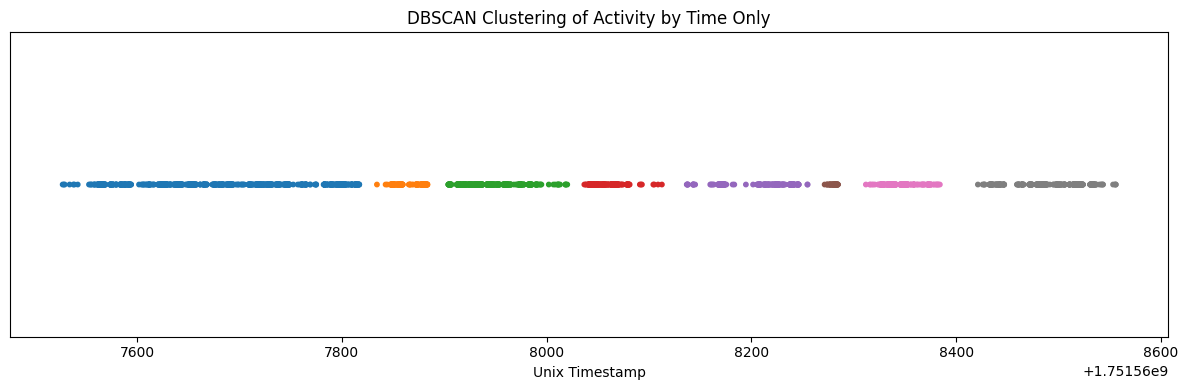

In [22]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sqlite3


def load_combined_activity_timestamps(db_path="screen_log.db"):
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()

    # Fetch timestamps from mouse clicks
    cur.execute("SELECT ts FROM mouse_clicks")
    mouse_rows = [ts[0] for ts in cur.fetchall()]

    # Fetch timestamps from keystrokes
    cur.execute("SELECT ts FROM keystrokes")
    key_rows = [ts[0] for ts in cur.fetchall()]

    # Combine and sort
    combined_raw = mouse_rows + key_rows
    combined = [datetime.fromisoformat(ts.replace("Z", "")) for ts in combined_raw]
    combined.sort()

    return combined


def cluster_with_dbscan(timestamps, eps=0.5, min_samples=3):
    unix_times = np.array([ts.timestamp() for ts in timestamps]).reshape(-1, 1)
    features = StandardScaler().fit_transform(unix_times)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(features)
    return labels


def plot_clusters(timestamps, labels):
    unix_times = [ts.timestamp() for ts in timestamps]
    colors = plt.cm.tab10((labels % 10).astype(int))

    plt.figure(figsize=(12, 4))
    plt.scatter(unix_times, [1]*len(unix_times), c=colors, s=10)
    plt.yticks([])
    plt.xlabel("Unix Timestamp")
    plt.title("DBSCAN Clustering of Activity by Time Only")
    plt.tight_layout()
    plt.show()


# --- Run it ---
timestamps = load_combined_activity_timestamps()
labels = cluster_with_dbscan(timestamps, eps=0.05, min_samples=4)
plot_clusters(timestamps, labels)
